# Pneumonia Chest X-ray Classification Notebook

In [7]:
# ===============================
# 1. Setup
# ===============================
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [8]:
# ===============================
# 2. Paths
# ===============================
# Kaggle dataset paths
DATA_DIR = "/kaggle/input/chest-xray-pneumonia/chest_xray"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "val")
TEST_DIR = os.path.join(DATA_DIR, "test")

# Working directory for repo files (after extracting zip)
WORK_DIR = "/kaggle/working/pneumonia-classification"
SRC_DIR = os.path.join(WORK_DIR, "src")

In [9]:
# ===============================
# 3. Quick EDA
# ===============================
import glob

for split, folder in zip(["Train", "Validation", "Test"], [TRAIN_DIR, VAL_DIR, TEST_DIR]):
    normal = len(glob.glob(os.path.join(folder, "NORMAL", "*.jpeg")))
    pneumonia = len(glob.glob(os.path.join(folder, "PNEUMONIA", "*.jpeg")))
    print(f"{split}: Normal={normal}, Pneumonia={pneumonia}")

Train: Normal=1341, Pneumonia=3875
Validation: Normal=8, Pneumonia=8
Test: Normal=234, Pneumonia=390


In [10]:
# ===============================
# 4. Data generators
# ===============================
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [11]:
# ===============================
# 5. Model - Transfer Learning (EfficientNetB0 from scratch)
# ===============================
from tensorflow.keras.applications import EfficientNetB0

# Pretrained weights kapalı (weights=None)
base_model = EfficientNetB0(weights=None, include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True  # tüm katmanları eğiteceğiz

model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 4,171,645 (15.91 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [12]:
# ===============================
# 6. Callbacks & Training
# ===============================
callbacks = [
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 198s 738ms/step - accuracy: 0.8189 - loss: 0.4570 - val_accuracy: 0.5000 - val_loss: 5.4514
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 537ms/step - accuracy: 0.9110 - loss: 0.2350 - val_accuracy: 0.5000 - val_loss: 5.6102
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 544ms/step - accuracy: 0.9375 - loss: 0.1654 - val_accuracy: 0.5000 - val_loss: 5.0062
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 546ms/step - accuracy: 0.9401 - loss: 0.1646 - val_accuracy: 0.5000 - val_loss: 4.2919
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 535ms/step - accuracy: 0.9536 - loss: 0.1355 - val_accuracy: 0.5000 - val_loss: 4.4534
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 544ms/step - accuracy: 0.9414 - loss: 0.1536 - val_accuracy: 0.6875 - val_loss: 1.1882
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 537ms/step - accuracy: 0.9518 - loss: 0.1274 - val_accuracy: 0.5000 - val_loss: 1.3846
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 549ms/step - accuracy: 0.9590 - loss: 

In [13]:
# ===============================
# 7. Fine-tuning (optional)
# ===============================
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Freeze all except last 20 layers
    layer.trainable = False

model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

ft_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=callbacks
)

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 122s 566ms/step - accuracy: 0.9607 - loss: 0.1101 - val_accuracy: 0.6250 - val_loss: 0.6944
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 531ms/step - accuracy: 0.9605 - loss: 0.1114 - val_accuracy: 0.6250 - val_loss: 0.5915
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 528ms/step - accuracy: 0.9594 - loss: 0.1043 - val_accuracy: 0.6250 - val_loss: 0.5809
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 527ms/step - accuracy: 0.9594 - loss: 0.1226 - val_accuracy: 0.6250 - val_loss: 0.5838
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 529ms/step - accuracy: 0.9621 - loss: 0.1069 - val_accuracy: 0.6250 - val_loss: 0.5086


20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 674ms/step
              precision    recall  f1-score   support

           0       0.93      0.59      0.72       234
           1       0.80      0.97      0.88       390

    accuracy                           0.83       624
   macro avg       0.86      0.78      0.80       624
weighted avg       0.84      0.83      0.82       624

ROC AUC: 0.9370589524435677


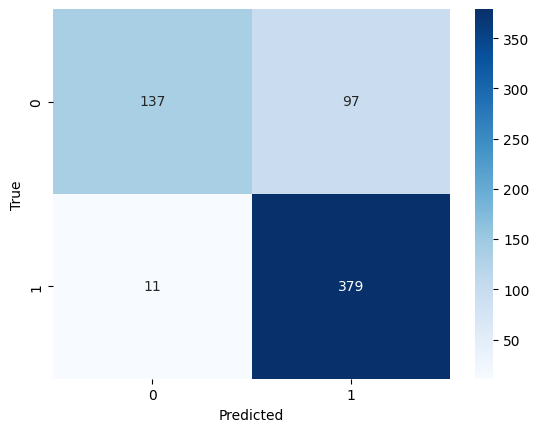

In [14]:
# ===============================
# 8. Evaluation
# ===============================
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

y_pred = model.predict(test_gen)
y_pred_classes = (y_pred > 0.5).astype(int)

print(classification_report(test_gen.classes, y_pred_classes))
print("ROC AUC:", roc_auc_score(test_gen.classes, y_pred))

cm = confusion_matrix(test_gen.classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, SeparableConv2D, DepthwiseConv2D

_CONV_TYPES = (Conv2D, SeparableConv2D, DepthwiseConv2D)

def find_last_conv_layer(model: Model) -> str:
    # İç içe modelleri de tarar, son görülen Conv2D-tabanlı katmanı döndürür
    stack = list(model.layers)
    last = None
    while stack:
        layer = stack.pop()
        if isinstance(layer, Model):
            stack.extend(layer.layers)
        if isinstance(layer, _CONV_TYPES):
            last = layer
    if last is None:
        raise ValueError("Modelde Conv2D tabanlı bir katman yok.")
    return last.name

@tf.function
def _gradcam_internal(img_tensor, grad_model, class_index: tf.Tensor):
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_tensor, training=False)
        if isinstance(preds, (list, tuple)):
            preds = preds[0]
        class_index = tf.cast(class_index, tf.int32)
        class_channel = preds[:, class_index]
    grads = tape.gradient(class_channel, conv_out)
    weights = tf.reduce_mean(grads, axis=(1, 2), keepdims=True)
    cam = tf.reduce_sum(weights * conv_out, axis=-1)  # (B,H,W)
    cam = tf.nn.relu(cam)
    cam_max = tf.reduce_max(cam, axis=(1, 2), keepdims=True)
    cam = tf.where(cam_max > 0, cam / cam_max, tf.zeros_like(cam))
    return cam

def make_gradcam_heatmap(
    img_array: np.ndarray,
    model: Model,
    target_layer: str | None = None,
    class_index: int | None = None,
):
    if target_layer is None:
        target_layer = find_last_conv_layer(model)

    last_conv = model.get_layer(target_layer)
    grad_model = Model(inputs=model.inputs, outputs=[last_conv.output, model.output])

    x = tf.convert_to_tensor(img_array)
    x = tf.cast(x, tf.float32)
    if x.dtype.is_integer or (hasattr(img_array, "dtype") and np.issubdtype(img_array.dtype, np.integer)):
        x = x / 255.0

    preds = grad_model(x, training=False)[1]
    if isinstance(preds, (list, tuple)):
        preds = preds[0]
    if class_index is None:
        class_ids = tf.argmax(preds, axis=-1)
    else:
        class_ids = tf.fill([tf.shape(preds)[0]], int(class_index))

    heatmaps = _gradcam_internal(x, grad_model, class_ids)
    return heatmaps.numpy(), target_layer, preds.numpy()


In [31]:
# ===============================
# 10. Save Model
# ===============================
model.save("final_pneumonia_model.h5")

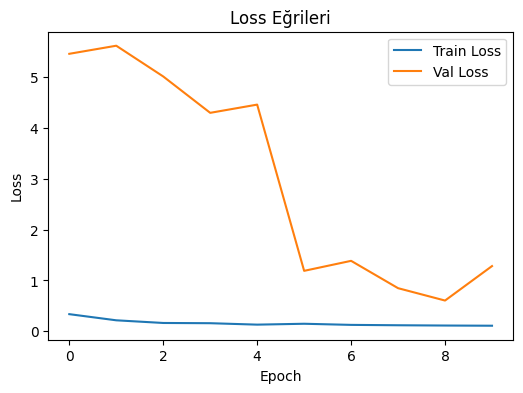

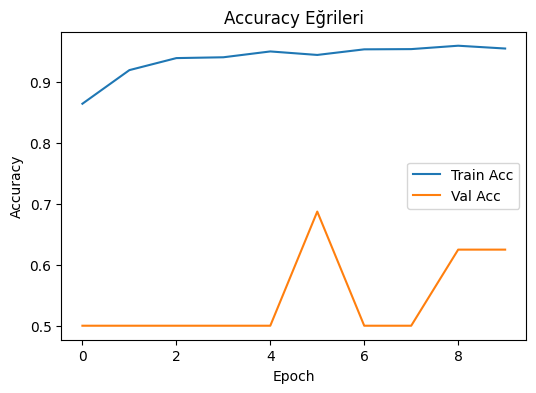

In [33]:
# ===============================
# 11. Loss Graph/Accuracy Graph
# ===============================
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Loss grafikleri
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss Eğrileri"); plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.show()

# Accuracy grafikleri
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title("Accuracy Eğrileri"); plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.show()
